In [2]:
import numba
from numba import jit
import numpy as np
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
% matplotlib inline

# The Multiple-Try Metropolis and its Variations

## Abstract

Markov Chain Monte Carlo (MCMC) has been extensively applied in many complicated computational problems to sample from an arbitrary distribution. The fundamental idea is to generate a Markov chain whose invariant distribution is the target distribution. The traditional Metropolis-Hastings algorithm (MH) based on local search may suffer from slow converging problem since the sampler may get stuck in a local mode especially for multimodal parameter spaces. Multiple-try Metropolis (MTM) was proposed to overcome this difficulty by proposing multiple trial points and then sampling based on their importance. The numerical experiments illustrate that the sampler can efficiently explore the parameter space. This project will prove the validity of MTM and implement the algorithm and its variations including Griddy-Gibbs Multiple-Try Metropolis (MTM-Gibbs) and Langevin-within-MTM on artificial data and real dataset. Comparisons are made to show the superiority of the algorithm over traditional MH algorithms.

## 1. Introduction

Monte Carlo statistical methods have been widely recognized as a essential part of the standard set of scientific computing. Particularly, MCMC has been extensively applied in many complicated computational problems in many different fields. The conceptual understanding about this algorithm is to draw samples approximately distributed from  a target distribution without directly sampling from it by constructing an ergodic Markov chain with the target distribution as the invariant distribution.

The traditional MH algorithm is one of the representatives of MCMC. This fundamental algorithm is powerful in the sense that it is highly flexible and can be adapted in terms of specific problems. One commonly used variation of the MH algorithm is the Gibbs sampler which ameliorate the difficulty that sampling from a multivariate distribution by alternatively sampling from the conditional distribution of each component. However, the key feature of these algorithms--proposing new trial samples based on local moves--often lead to unsatisfactory properties of the samples. Specifically, the algorithms may suffer from slow convergence and the samples can be highly correlated which result in the difficulty on making statistical inferences. In addition, trapping in local mode is also a major imperfection of this algorithm. 

A natural idea is to enlarge the area for the proposal while it often comes along a small MH ratio resulting in an inefficient algorithm. To mitigate this problem, Liu, Liang and Wong (2000) proposed MTM method. This method differs from the classical MH by proposing a multiple candidate points rather than a simple point for each iteration. As a result, the algorithm is more robust and efficient for effectively exploring the state space of parameters.

This project intends to study the MTM algorithm to a further extent. Since no existing code was found on these methods, we will concentrate on developing code of them rather than providing a highly optimized code (Note that it is limited to optimize the code for MCMC algorithm since to build a Markov chain, the algorithm has to be implemented sequentially rather than in parallel.). We will provide only one version of code after optimization by vectorization of the functions and using jit tools in package numba. In fact, all the for loops in the code is performing sequential MCMC samplings (can not be cancelled further).

The rest of this project is organized as follows. In section 2, A general form of the MTM algorithm is provided and theoretically proved to be valid. Two variations, MTM-Gibbs and Langevin-within-MTM, are discussed. In section 3, the algorithms are implemented on two artificial examples and one real dataset. Comparisons with other state-of-the-art algorithms are made to demonstrate the superiority of the MTM algorithm. We conclude with some final comments in section 4.

## 2. The algorithm and its variations

In this section, we will introduce the multiple-try metropolis as well as its variations. In the traditional MH algorithm, some basic settings are as follows. Firstly, let $T(x_i,x_{i+1})$ be a transition function which defines the probability that transition from $x_i$ to $x_{i+1}$. Next, a score function used for evaluating trial points is defined as follows,
\begin{equation*}
w(x_i,x_{i+1}) = \pi(x_i) T(x_i,x_{i+1}) \lambda (x_i,x_{i+1})
\end{equation*}
where $\pi$ is the target distribution and $\lambda (x_i,x_{i+1})$ is an adjustment function to enhance the power of the algorithm, which is nonnegative and symmetric.

Two basic requirements should be satisfied.
1. $T(x_{i},x_{i+1})  > 0$ if and only if $T(x_{i+1},x_i)  > 0$
2. If $T(x_{i},x_{i+1})  > 0$, then $\lambda (x_i,x_{i+1}) >0$
The choices of $\lambda (x_i,x_{i+1})$ may vary under different situations. 

### 2.1 General form of Multiple-try Metropolis

#### 2.1.1 Algorithm

The MTM algorithm can be achieved through 4 steps.  
1. Sample $k$ iid trials $x_{t+1}^{1},..., x_{t+1}^{k}$ from $T(x_i, \cdot)$. Compute $w(x_{t+1}^{j},x_{t})$ for $j=1,...,k$.
2. Select $x = x_{t+1}$ among the proposal set $\{x_{t+1}^{1},..., x_{t+1}^{k}\}$ with probability propotional to $\{w(x_{t+1}^{1},x_t),...,w(x_{t+1}^{k},x_t)\}$.
3. Sample $x_{\star}^{1},...,x_{\star}^{k-1}$ from the distribution $T(x_{t+1},\cdot)$, and let $x_{\star}^{k}=x_{t}$.
4. Accept $x$ with probability 
$$
r = \text{min}\left\{ 1, \frac{w(x_{t+1}^{1},x_{t})+\cdot \cdot \cdot+w(x_{t+1}^{k},x_{t})} {w(x_{\star}^{1},x_{t+1})+\cdot \cdot \cdot+w(x_{\star}^{k},x_{t+1})} \right\}
$$
and reject it with probability $1-r$. The quantity $r$ is called generlaized MH ratio. 

#### 2.1.2 Theoretical Justification

The reversibility of the Markov chain is justified by proving the detailed balance condition.

Let $P(x_{i},x)$ be the actual transition probability from $x_{i}$ to $x$.  Then we have
\begin{align*}
\pi(x_i)P(x_{i},x)&=\pi(x_i)\mathsf{P}\bigg[\bigcup_{j=1}^k\{(x_{i+1}^j=x)\cap (x_{i+1}^j \text{is chosen})\}x_{i}\bigg]\\
&=k\pi(x_i)\mathsf{P}[(x_{i+1}^k=x)\cap (x_{i+1}^k \text{is chosen})\}x_{i}]\quad \text{(since $x_{i+1}^j$ are exchangeable)}\\
&=k\pi(x_i)\int\cdots\int T(x_{i},x)T(x_{i},x_{i+1}^1)\cdots T(x_{i},x_{i+1}^{k-1})\quad \text{(choosing $y,y_1,...,y_{k-1}$)}\\
&\quad\times \frac{w(x,x_{i})}{w(x,x_{i})+\sum_{j=1}^{k-1}w(x_{i+1}^j,x_i)}\quad \text{(selecting $y$)}\\
&\quad\times \text{min}\left\{ 1, \frac{w(x,x_{i})+\sum_{j=1}^{k-1}w(x_{i+1}^{j},x_{i})}{w(x_{i},x)+\sum_{j=1}^{k-1}w(x_{\star}^{j},x)} \right\}\quad \text{(accepting $y$)}\\
&\quad\times T(x,x_{\star}^1)\cdots T(x,x_{\star}^{k-1})d x_{i+1}^1\cdots dx_{i+1}^{k-1}dx_{\star}^1\cdots dx_{\star}^{k-1}\quad \text{(choosing $x_{\star}^1,...,x_{\star}^{k-1}$)}\\
&=k\frac{w(x_{i},x)w(x,x_{i})}{\lambda(x_{i},x)}\int\cdots\int \text{min}\left\{ \frac{1}{w(x,x_{i})+\sum_{j=1}^{k-1}w(x_{i+1}^j,x_{i})}, \frac{1}{w(x_{i},x)+\sum_{j=1}^{k-1}w(x_{\star}^{j},x)} \right\}\\
&\quad\times T(x,x_{\star}^1)\cdots T(x,x_{\star}^{k-1})d x_{i+1}^1\cdots dx_{i+1}^{k-1}dx_{\star}^1\cdots dx_{\star}^{k-1}\\
&=\pi(x)P(x,x_{i})
\end{align*}

Therefore, this method will produce an ergodic Markov chain leaving $\pi$ as the invariant distribution.

### 2.2 Two variations

#### 2.2.1 Griddy Gibbs Multiple-Try Metropolis

One of the major characteristic of the Gibbs sampler is that it is constructed based on the conditional distribution. However, in many cases, it is intractable to derive the conditional distribution analytically for sampling. The griddy Gibbs sampler (Ritter and tanner (1992)) solves this computational challenge by assigning grids for each component and approximating the target conditional distributions through evaluating the values of conditional distributions on grids. However, when the dimension of joint distribution is high or the conditional distribution is not concentrated on a small support. This approximation can be very computationally expensive and not accurate. 

Combining Gibbs sampler with MTM method, the MTM-Gibbs algorithm is designed to imitate the behaviour of Griddy Gibbs but has a much less computation cost and the invariant distribution is exactly the target distribution instead of approximation. Assume $\pi(x)$ is a $d$-dimensional target distribution. Let $x =(x(1),...,x(d))$, the algorithm of MTM-Gibbs is illustrated as follows,

1. Select any element of $x$, say $x(i)$. Sample $y_1,..., y_k$ iid from a transition function $T(x(i),.)$ in line with the direction of $x(i)$, and calculate 
\begin{equation*}
w(y_j,x(i)) = \pi(x(1),...,x(i-1),y_j,x(i+1),...,x(d)) T(y_j,x(i)) \lambda(y_j,x(i)),
\end{equation*}
for j = 1,2,...,k.

2. Select $y=y_j$ with probability proportional to $w(y_j,x(i))$. 

3. Draw $k-1$ iid samples from T(y,\cdot), denote by $s_1,...,s_{k-1}$. Make $s_k=x(i)$.

4. Compute the generalized Metropolis ratio $r$ defined above, accept $y$ with probability $r$ and reject it with $1-r$.

#### 2.2.2 Langevin-within-MTM

Hamiltonian Monte Carlo (HMC) has gained increasingly interest in statistical and machine learning. It takes advantage of the derivative of the pdf (up to a normalizing constant) of the target distribution and lead to a highly efficient sampling algorithm. However, it is widely misused in many fields since people do not check state spaces before performing HMC algorithms. When the state space is multimodal, the algorithm can easily get stuck in a local mode by using the derivatives lead to undesired slow convergence and biased estimation. 

Here we consider combining Langevin sampling method (a special case of HMC, take one step at each time) with MTM to provide a more reliable and robust algorithm which can explore the state space sufficiently large. Hamiltonian dynamics can be intrinsically embedded within the MTM as follows,

1. Sample $k$ iid trials $x_{t+1}^{1},..., x_{t+1}^{k}$ using Langevin dynamics. Compute $w(x_{t+1}^{j},x_{t})$ for $j=1,...,k$.
2. Select $x = x_{t+1}$ among the proposal set $\{x_{t+1}^{1},..., x_{t+1}^{k}\}$ with probability propotional to $\{w(x_{t+1}^{1},x_t),...,w(x_{t+1}^{k},x_t)\}$.
3. Sample $x_{\star}^{1},...,x_{\star}^{k-1}$ using Langevin dynamics, and let $x_{\star}^{k}=x_{t}$.
4. Accept $x$ with probability 
$$
r = \text{min}\left\{ 1, \frac{w(x_{t+1}^{1},x_{t})+\cdot \cdot \cdot+w(x_{t+1}^{k},x_{t})} {w(x_{\star}^{1},x_{t+1})+\cdot \cdot \cdot+w(x_{\star}^{k},x_{t+1})} \right\}
$$
and reject it with probability $1-r$. The quantity $r$ is called generlaized MH ratio. 

## 3. Implementation and comparisons

### 3.1 Illustrative example: two dimensional mixture Gaussian distribution

Gaussian mixture models are widely used in statistical modelling in both academia and industry. Efficiently sampling from mixture models is a key issue in many applications. The sampling algorithms may converge slowly if distances between modes of Gaussian distributions are large or some of Gaussians are highly correlated. We will illustrate the arguments above by performing and comparing MTM algorithm and traditional MH algorithm on a two dimensional Gaussian mixture distribution.

#### 3.1.1 Model Specification: Mixture Gaussian distribution

The target mixture Gaussian distribution is given by:

$$
\pi(x)=\frac{1}{3}\mathbf{N}_2(\mathbf{0},\mathbf{I}_2)+\frac{1}{3}\mathbf{N}_2\biggl\{\left(\begin{array}{c}
-6 \\
-6
\end{array}
\right),\left(\begin{array}{cc}
1 & 0.9 \\
0.9 & 1
\end{array}
\right)
\biggr\}+\frac{1}{3}\mathbf{N}_2\biggl\{\left(\begin{array}{c}
4 \\
4
\end{array}
\right),\left(\begin{array}{cc}
1 & -0.9 \\
-0.9 & 1
\end{array}
\right)
\biggr\}$$
This is a mixture of three Gaussian distributions and one can see that the modes of them are moderate and one of them is highly positively correlated while one of them is highly negatively correlated which is visualized in the figure below. 

In [3]:
## Gaussian mixtrue pdf contour plot

# assign grids
x = y = np.linspace(-10,8,400)
X, Y = np.meshgrid(x,y)

# evaluate pdf of each Gaussian
Z1 = mlab.bivariate_normal(X, Y, 1.0, 1.0, -6, -6, 0.9)
Z2 = mlab.bivariate_normal(X, Y, 1.0, 1.0, 4, 4, -0.9)
Z3 = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0)

# mix three Gaussians
Z = (Z1+Z2+Z3)/3

/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


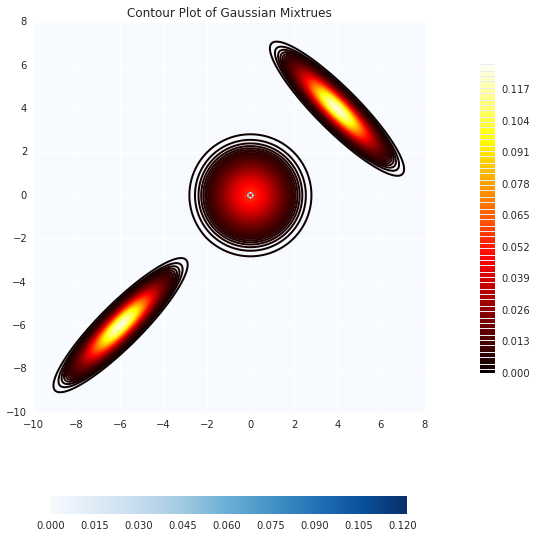

In [4]:
# figure size
plt.figure(figsize=(10,10)) 


plt.hot()                                   
im = plt.imshow(Z, interpolation='bilinear', origin='lower', cmap=cm.Blues, extent=(-10,8,-10,8))

# levels
levels = np.arange(0, 0.13, 0.001) 

CS = plt.contour(Z, levels,origin='lower',linewidths=2, extent=(-10,8,-10,8))         

CB = plt.colorbar(CS, shrink=0.8, extend='both')

CBI = plt.colorbar(im, orientation='horizontal',shrink=0.8)

l,b,w,h = plt.gca().get_position().bounds
ll,bb,ww,hh = CB.ax.get_position().bounds
CB.ax.set_position([ll, b+0.1*h, ww, h*0.8])      

plt.title('Contour Plot of Gaussian Mixtrues')  
plt.show()

The following settings are used in this example.

***Method 1: Metropolis-Hastings***

Initial state: 
$x_0^{i} \sim \textsf{Uni}(-5,5)\quad i = 1,2$

The proposal function $T(\cdot,\cdot)$:
$$
\textsf{N}_2\left(\left[\begin{array}{c}
x_{t}^{1}  \\
x_{t}^{2} 
\end{array}
\right],\sigma^2I_2\right)
$$

***Method 2: MTM***

Initial state: 
$x_0^{i} \sim \textsf{Uni}(-5,5)\quad i = 1,2$

The proposal function $T(\cdot,\cdot)$:
$$
\textsf{N}_2\left(\left[\begin{array}{c}
x_{t}^{1}  \\
x_{t}^{2} 
\end{array}
\right],\sigma^2I_2\right)
$$

$\lambda(x_t,x_{t+1})$  is selected to be constant 1.

#### 3.1.2 Implementation (with vectorization and optimization using jit)

In [110]:
@jit
def norm_mix(x):
    """
    Calculate the value of the pdf of Gaussian mixture distribution.
    
    arguments:
    
    x: a vector with length 2 or a matrix of dimension n * 2
    
    return:
    
    target: the pdf of the target distribution evaluated at x
    """
    
    target = stats.multivariate_normal.pdf(x,[0,0],[[1,0],[0,1]])+stats.multivariate_normal.pdf(x,[-6,-6],[[1,0.9],[0.9,1]])+stats.multivariate_normal.pdf(x,[4,4],[[1,-0.9],[-0.9,1]])
    return target

***Method 1: Traditional Metropolis-Hastings sampler***

In [111]:
# total iterations of MH
n_iter = 30000

# tuning parameter:
# sigma^2: variance of proposal
sigma = 2

# initial state
X = stats.uniform.rvs(loc=-5, scale=10, size=2, random_state=None)

# record the number of acceptances
accept = 0

# store the samples
MHsamples = np.zeros((n_iter,2))

In [112]:
def T(x,y,sigma):
    """
    Calculate the transition probability.
    
    arguments:
    
    x: a vector with length 2 or a matrix of dimension n * 2
    y: a vector with length 2 or a matrix of dimension n * 2
    sigma: standard deviation of the proposal
    
    return:
    
    T: the transition probability from x to y
    """
    return stats.multivariate_normal.pdf(y,x,[[sigma**2,0],[0,sigma**2]])

In [113]:
# MH sampler
for t in range(n_iter):
    
    # proposal: independent N(0,sigma)
    Y = X+stats.norm.rvs(0,sigma,2)
       
    # accept or reject
    u = stats.uniform.rvs(loc=0, scale=1, size=1)
    
    # acceptance probability
    r = norm_mix(Y)*T(Y,X,sigma)/norm_mix(X)/T(X,Y,sigma)
    if u < r:
        X = Y
        accept += 1
    MHsamples[t] = X

In [85]:
print('acceptance rate:',accept/n_iter)

acceptance rate: 0.21116666666666667


The acceptance rate is small which lead to an inefficient algorithm. One can see the acceptance rate for MTM sampler later is much higher under the same settings

/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


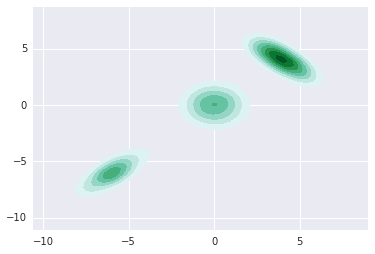

In [45]:
# contour plot of the samples
sns.kdeplot(MHsamples[:,0], MHsamples[:,1], camps='Reds', kind="kde",shade=True,shade_lowest=False)

Clearly, the samples given by MH algorithm are more concentrated at $\mathbf{N}_2\biggl\{\left(\begin{array}{c}
4 \\
4
\end{array}
\right),\left(\begin{array}{cc}
1 & -0.9 \\
-0.9 & 1
\end{array}
\right)
\biggr\}$ which verifies our arguments above.

***Method 2: MTM sampler (with vectorization)***

In [9]:
# same settings as MH sampler
n_iter = 30000
sigma = 2

# the value of k, the number of trials each time
M = 10

# initial state
X = stats.uniform.rvs(loc=-5, scale=10, size=2, random_state=None)

# record the number of acceptances
accept = 0

# store the samples
MTMsamples = np.zeros((n_iter,2))

In [10]:
# MTM sampler
for t in range(n_iter):
    # proposal: independent N(0,sigma^2)
    Y = np.tile(X,(M,1))+stats.norm.rvs(0,sigma,(M,2))
    
    # proposal importance probabilities
    w_prop = norm_mix(Y)*T(X,Y,sigma)
    
    # index of the chosen trial point
    ix = np.random.choice(M, 1, p=w_prop/sum(w_prop))
    
    # draw M-1 samples 
    X_star = np.tile(Y[ix],(M-1,1))+stats.norm.rvs(0,sigma,(M-1,2))
    # add X as M th sample
    X_star = np.vstack((X_star,X))
    
    # back importance probabilities
    w_back = norm_mix(X_star)*T(Y[ix][0],X_star,sigma)
    
    # accept or reject
    u = stats.uniform.rvs(loc=0, scale=1, size=1)
    
    # acceptance probability
    r = sum(w_prop)/sum(w_back)
    if u < r:
        X = Y[ix][0]
        accept += 1
    MTMsamples[t] = X

In [89]:
print('acceptance rate:',accept/n_iter)

acceptance rate: 0.6267


Under the same settings as MH sampler, the acceptance rate for MTM sampler is much higher implying MTM is more efficient.

/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


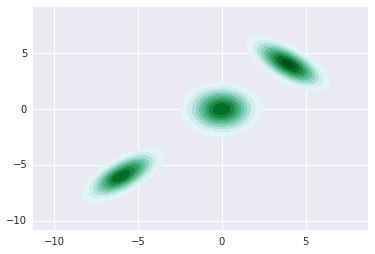

In [50]:
# contour plot of the samples
sns.kdeplot(MTMsamples[:,0], MTMsamples[:,1], camps='Reds', kind="kde",shade=True,shade_lowest=False)

The contour plot of the samples using MTM sampler is consistent with the contour plot of the pdf above which is much better than MH sampler.

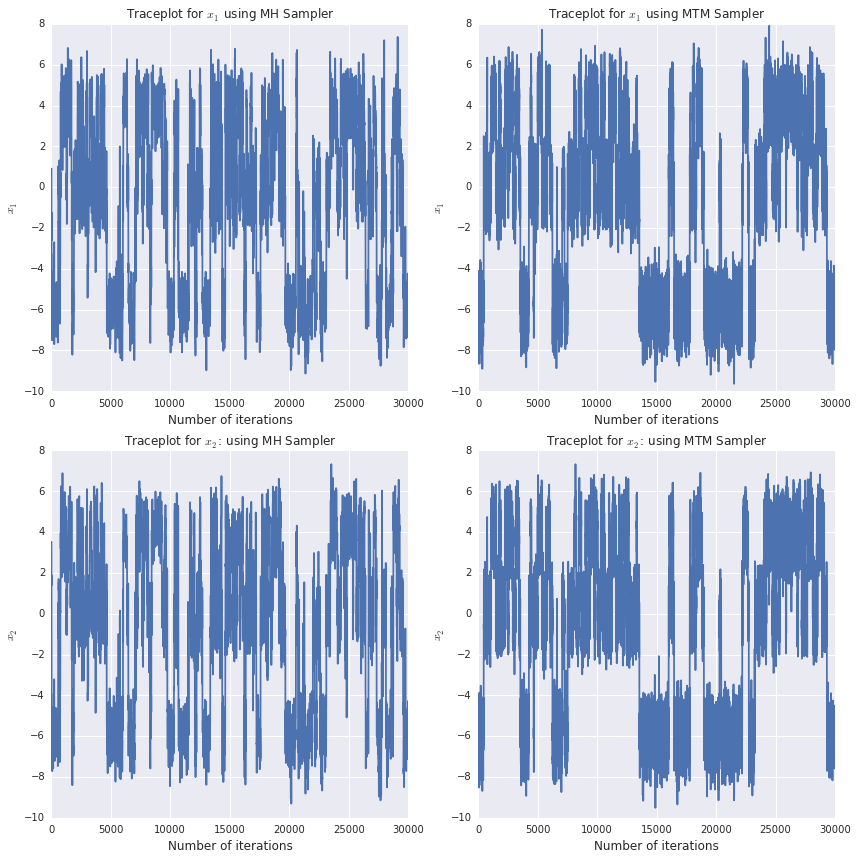

In [11]:
## Traceplots of samples using two methods
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

# theta_1 using MH
axes[0,0].plot(range(n_iter),MHsamples[:,0])
axes[0,0].set_title("Traceplot for " r"$x_1$ using MH Sampler",size=12)
axes[0,0].set_ylabel(r"$x_1$",size=12)
axes[0,0].set_xlabel("Number of iterations",size=12)

# theta_1 using MTM
axes[0,1].plot(range(n_iter),MTMsamples[:,0])
axes[0,1].set_title("Traceplot for " r"$x_1$ using MTM Sampler",size=12)
axes[0,1].set_ylabel(r"$x_1$",size=12)
axes[0,1].set_xlabel("Number of iterations",size=12)

# theta_2 using MH
axes[1,0].plot(range(n_iter),MHsamples[:,1])
axes[1,0].set_title("Traceplot for " r"$x_2$: using MH Sampler",size=12)
axes[1,0].set_ylabel(r"$x_2$",size=12)
axes[1,0].set_xlabel("Number of iterations",size=12)

# theta_2 using MTM
axes[1,1].plot(range(n_iter),MTMsamples[:,1])
axes[1,1].set_title("Traceplot for " r"$x_2$: using MTM Sampler",size=12)
axes[1,1].set_ylabel(r"$x_2$",size=12)
axes[1,1].set_xlabel("Number of iterations",size=12)

fig.tight_layout()

From the traceplot, we could see that the MH sampler is concentrated more at $\mathbf{N}_2\biggl\{\left(\begin{array}{c}
4 \\
4
\end{array}
\right),\left(\begin{array}{cc}
1 & -0.9 \\
-0.9 & 1
\end{array}
\right)
\biggr\}$ which means that the samples will be biased and highly correlated using MH sampler.

### 3.2 Griddy Gibbs Multiple-Try Metropolis on real dataset: Biochemical Oxygen Demand (BOD)

BOD dataset is originally from Marske (1967) which was used to analyse the relationship between BOD $y$ and time $x$. We adopt a non-linear model given by Bates and Watts (1988)  which is
$$y_i=\theta_1(1-\exp(-\theta_2x_i))+\varepsilon_i$$
where $y$ is the BOD at time $x$ with independent normal errors with constant variance $\sigma^2$. Assuming a flat prior on $\sigma^2$ and marginalize it out, we get posterior
$$\pi(\theta_1,\theta_2\mid x,y)\propto [S(\theta_1,\theta_2)]^{-(\frac{n}{2}-1)}$$
where $n$ is the sample size and $S$ is the usual sum of squared error.

Since the posterior is two dimensional and has a complicated form (since it involves SSE), Griddy Gibbs may be the best tool to handle this issue. In fact, by analytical result, the posterior will be concentrated on two parts (see figure below). The difficulty for Griddy Gibbs sampler lies in that the sampler may give more weights on one local mode. Also, it requires evaluating a large range of parameter if Griddy Gibbs sampler is used which is inefficient.

#### 3.2.1 Model Specification: Non-linear model

Technically, we will assume a uniform prior for $\theta_1$ and $\theta_2$ on the region $[-20,50]\times[-2,6]$ to guarantee that the posterior is proper.

In [100]:
## read in data
data = pd.read_table('BOD.txt',sep='|')

## show the head of the data
data.head()

,Time,demand
1,1,8.3
2,2,10.3
3,3,19.0
4,4,16.0
5,5,15.6


In [101]:
# define response y and feature x
x = data.ix[:,0]
y = data.ix[:,1]

In [102]:
@jit
def post(theta1, theta2):
    """
    Calculate the posterior.
    
    arguments:
    
    theta1: a scaler or a vector of the values of theta_1
    theta2: a scaler or a vector of the values of theta_2
    
    return:
    
    posterior: the posterior evaluated at (theta_1,theta_2)
    """
    n = len(x)
    if theta1 > -20 and theta1 < 50 and theta2 > -2 and theta2 < 6:
        posterior = sum((y - theta1*(1-np.exp(-theta2*x)))**2)**(-(n/2)+1)
    else: posterior = 0
    return posterior

In [103]:
## plot the contour plot of the posterior

# grids for x-axis and y-axis
xaxis = np.linspace(-20.0, 40.0, 120)
yaxis = np.linspace(-2.0, 4.0, 120)

# evaluate the posterior at grids
Z = np.reshape(np.array([post(a,b) for a in xaxis for b in yaxis]),newshape=[120,120])

/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


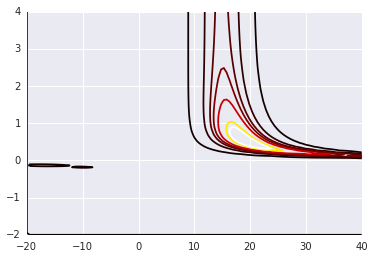

In [77]:
# plot the contour plot of the posterior
plt.contour(xaxis, yaxis, Z.T, levels=[0,0.00001,0.00004,0.00008,0.00012,0.00020,0.0005,0.0007])

The following settings are used in this example.

***Griddy Gibbs MTM***

Initial state: $\theta_0^i = \text{Uni}(-1,1) \quad i = 1,2$

The proposal function $T(\cdot,\cdot)$:
$$\mathbf{N}(\theta_{t+1}^{i},\sigma^2)\quad i = 1,2$$

The adjustment function $\lambda (\theta_t,\theta_{t+1}) = 1$

#### 3.2.2 Implementation (with vectorization and optimization using jit)

In [104]:
# total iterations
n_iter = 10000

# the value of k, the number of trials each iteration
M = 10

# tuning parameter:
# sigma1^2, sigma2^2: variance of the proposal
sigma1 = 30
sigma2 = 3

In [115]:
@jit
def T(x,y,sigma):
    """
    Calculate the transition probability.
    
    arguments:
    
    x: a vector with length 2 or a matrix of dimension n * 2
    y: a vector with length 2 or a matrix of dimension n * 2
    sigma: standard deviation of the proposal
    
    return:
    
    T: the transition probability from x to y
    """
    return stats.norm.pdf(y,x,sigma)

In [116]:
# MTM-Gibbs sampler
def MTMG(n_iter, M, sigma1, sigma2, post):
    """
    Griddy Gibbs MTM sampler
    
    arguments:
    
    n_iter: total number of iterations
    
    M: the value of k, the number of trials each iteration

    sigma1: tuning parameter, standard deviation of the proposal for theta_1
    sigma2: tuning parameter, standard deviation of the proposal for theta_2
   
    post: a function to calculate posterior
    
    return:
    
    MTMGsamples: samples by Griddy Gibbs MTM sampler
    count1: the number of updating theta_1
    count2: the number of updating theta_2
    accept1: the number of acceptance for parameter theta_1
    accept2: the number of acceptance for parameter theta_2
    """
    # initial state
    theta1, theta2 = stats.uniform.rvs(loc=-1, scale=2, size=2, random_state=None)

    # record the number of updates for each component
    count1 = count2 = 0

    # record the number of acceptances
    accept1 = accept2 = 0
    
    # store the samples
    MTMGsamples = np.zeros((n_iter,2))

    for t in range(n_iter):
    
        # randomly pick the updating component
        index = stats.bernoulli.rvs(0.5,1)
    
        # update theta1
        if index == 1:
        
            # record number of updating
            count1 += 1
        
            # proposal: N(theta1,sigma1^2)
            theta1_prop = np.repeat(theta1,M)+stats.norm.rvs(0,sigma1,M)
    
            # proposal importance probabilities
            w_prop = np.array([post(theta1,theta2) for theta1 in theta1_prop])*T(theta1_prop,theta1,sigma1)
     
            # index of the chosen trial point
            ix = np.random.choice(M, 1, p=w_prop/sum(w_prop))
    
            # draw M-1 samples 
            theta1_star = np.repeat(theta1_prop[ix],M-1)+stats.norm.rvs(0,sigma1,M-1)
            # add theta1 as M th sample
            theta1_star = np.append(theta1_star,theta1)
    
            # back importance probabilities
            w_back = np.array([post(theta1,theta2) for theta1 in theta1_star])*T(theta1_star,theta1_prop[ix],sigma1)
    
            # accept or reject
            u = stats.uniform.rvs(loc=0, scale=1, size=1)
            if u < sum(w_prop)/sum(w_back):
                theta1 = theta1_prop[ix]
                accept1 += 1
            
        # update theta2
        else: 
        
            # record number of updating
            count2 += 1
        
            # proposal: N(theta2,sigma2^2)
            theta2_prop = np.repeat(theta2,M)+stats.norm.rvs(0,sigma2,M)
    
            # proposal importance probabilities
            w_prop = np.array([post(theta1,theta2) for theta2 in theta2_prop])*T(theta2_prop,theta2,sigma2)
    
            # index of the chosen trial point
            ix = np.random.choice(M, 1, p=w_prop/sum(w_prop))
    
            # draw M-1 samples 
            theta2_star = np.repeat(theta2_prop[ix],M-1)+stats.norm.rvs(0,sigma2,M-1)
            # add theta2 as M th sample
            theta2_star = np.append(theta2_star,theta2)
    
            # back importance probabilities
            w_back = np.array([post(theta1,theta2) for theta2 in theta2_star])*T(theta2_star,theta2_prop[ix],sigma2)
    
            # accept or reject
            u = stats.uniform.rvs(loc=0, scale=1, size=1)
            if u < sum(w_prop)/sum(w_back):
                theta2 = theta2_prop[ix]
                accept2 += 1
            
        MTMGsamples[t] = theta1, theta2
    
    return MTMGsamples, count1, count2, accept1, accept2

In [117]:
# implement the Griddy Gibbs MTM sampler
MTMGsamples, count1, count2, accept1, accept2 = MTMG(n_iter=n_iter, M=M, sigma1=sigma1, sigma2=sigma2, post=post)

/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


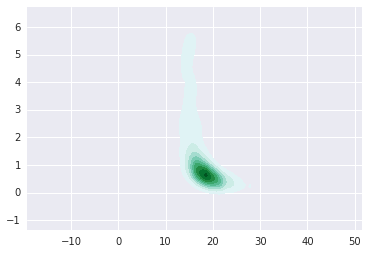

In [22]:
# contour plot of samples
sns.kdeplot(MTMGsamples[:,0], MTMGsamples[:,1], camps='Reds', kind="kde",shade=True,shade_lowest=False)

/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


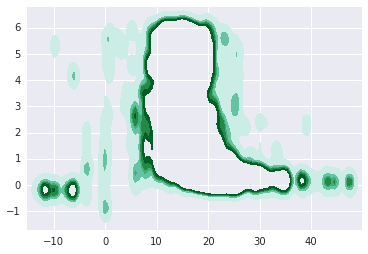

In [32]:
# contour plot of samples
sns.kdeplot(MTMGsamples[:,0], MTMGsamples[:,1], camps='Reds', kind="kde",shade=True,shade_lowest=False,levels=[0,0.0001,0.0005,0.0007,0.0008,0.001,0.0012])

Therefore, we can see from the second contour plot, the samples detect the other small peak. For here, we meant to stress that Griddy Gibbs MTM sampler can also be adapted to sample from such distribution which Griddy Gibbs is generally recognized as the best method to do it. And it is much faster than Griddy Gibbs sampler. Therefore, we do not code the Griddy Gibbs sampler since it requires evaluating the posterior over a large range of grids ($[-20,50]\times[-2,6]$) which is much slower. 

## 3.3 Langevin-within-MTM: Double well potential function 

The advantage of HMC type algorithms lies in the use of derivatives. It convert random walks to local mode search which is considered to be more efficient. However, when the state space is multimodal, this advantage may become disaster since it may easily get stuck in local modes.

In this session, we will illustrate Langevin-within-MTM algorithm by sampling from a distribution of the form
$$\pi(\theta)\propto \exp(-U(\theta))$$
where $U(\theta)$ is a so-called double well potential function defined as 
$$U(\theta)=(\theta+4)(\theta+1)(\theta-1)(\theta-3)/14+0.5$$
(Ding et al., 2014)

The plot of $\pi(\theta)$ is provided below. Clearly, it has two modes. We will compare Langevin and Langevin-within-MTM under the same settings to show that the later one can efficiently explore the state space.

In [33]:
# define potential energy
@jit
def U(theta):
    """
    Potential energy
    
    argument:
   
    theta: a scaler or a vector of value(s) of theta
    
    return:
    
    U: the energy evaluated at theta
    """
    return (theta+4)*(theta+1)*(theta-1)*(theta-3)/14+0.5

In [78]:
# define the derivative of potential energy
@jit
def grad_U(theta):
    """
    Potential energy
    
    argument:
   
    theta: a scaler or a vector of value(s) of theta
    
    return:
    
    grad_U: the derivative of potential energy
    """
    return 1/14*(4*theta**3+3*theta**2-26*theta-1)

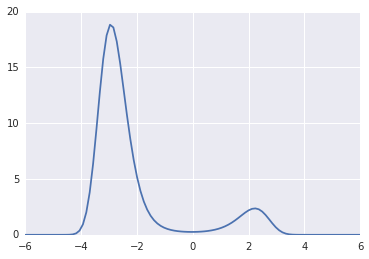

In [35]:
x = np.linspace(-6, 6, 100)
plt.plot(x, np.exp(-U(x)))
pass

#### 3.3.1 Model specification

***Method 1: Langevin type algorithm***

Initial state: $\theta_0 = \text{Uni}(-6,6)$

$p$ is defined as following independent standard normal distribution and hence the kinetic energy $K(p)=\frac{p^2}{2}$:

The tunning parameter $\varepsilon$ is setted to be 0.1

***Method 2: Langevin-within-MTM algorithm***

Initial state: $\theta_0 = \text{Uni}(-6,6)$

$p$ is defined as following independent standard normal distribution and hence the kinetic energy $K(p)=\frac{p^2}{2}$:

The tunning parameter $\varepsilon$ is setted to be 0.1 and the number of trials for each iteration is 5.

#### 3.3.2 Implementation (with vectorization and optimization using jit)

***Method 1: Langevin type algorithm***

In [79]:
# Langevin type algorithm
@jit
def Langevin(U, grad_U, eps, current_q, M):
    """
    Langevin type update
    
    argument:
    
    U: energy function
    grad_U: the derivative of the energy function
    eps: tunning parameter, value of the step size 
    current_q: initial position
    M: the value of k, the number of trials for each iteration (when k=1, it is the traditional Langevin algorithm)
    
    return:
    
    q: vector of length M containing the proposed new positions
    w: vector of length M containing importance probabilities for q[i] 
    """
    
    # record initial value of q
    q = current_q
    
    # sample p from N(0,1)
    p = np.random.randn(M)
    
    # record inital value of p
    current_p = p
    
    # a half step for momentum initially
    p = p - eps * grad_U(q)/2
    
    # a full step for position and momentum
    q = q + eps * p
    
    # another half step for momentum
    p = p - eps * grad_U(q)/2
    
    # negate momentum to make the proposal symmetric
    p = -p
    
    # evaluate potential energy and kinetic energy
    current_U = U(current_q)
    current_K = current_p**2/2
    proposed_U = U(q)
    proposed_K = p**2/2
    
    # acceptance probability
    w = np.exp(current_U-proposed_U+current_K-proposed_K)
        
    return q,w

In [80]:
# total iterations
n_iter = 20000

# tuning parameter:
eps=0.1

In [81]:
# initial state
q = stats.uniform.rvs(loc=-6, scale=12, size=1, random_state=None)

# record the number of acceptances
accept = 0

# store the samples
Langevin_samples = np.zeros(n_iter)

In [90]:
# Langevin sampler
for t in range(n_iter):
        
    # proposal importance probabilities
    q_prop, w_prop = Langevin(U, grad_U, eps=eps, current_q=q, M=1)
    
    
    u = stats.uniform.rvs(loc=0, scale=1, size=1)
    if u < w_prop:
        q = q_prop
        accept += 1
    Langevin_samples[t] = q

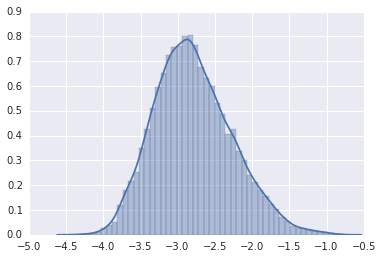

In [91]:
# histogram and kde of the samples
sns.distplot(Langevin_samples)

Clearly, the Langevin sampler gets stuck in one of the mode.

***Method 2: Langevin-within-MTM algorithm***

In [71]:
# initial state
q = stats.uniform.rvs(loc=-6, scale=12, size=1, random_state=None)

# record the number of acceptances
accept = 0

# store the samples
LMTMsamples = np.zeros(n_iter)

In [72]:
# Langevin-within-MTM sampler
for t in range(n_iter):
        
    # proposal importance probabilities
    q_prop, w_prop = Langevin(U, grad_U, eps=eps, current_q=q, M=M)
    
    # index of the chosen trial point
    ix = np.random.choice(M, 1, p=w_prop/sum(w_prop))
    
    # draw M-1 samples 
    q_star, w_back = Langevin(U, grad_U, eps=eps, current_q=q_prop[ix], M=M-1)
    
    # add X as M th sample
    q_star = np.append(q_star,q)
    
    # back importance probabilities
    p = (q-q_prop[ix])/eps
    w_back = np.append(w_back,np.exp(U(q_prop[ix])+(p+eps*grad_U(q_prop[ix]))**2/2-U(q)-(p-eps * grad_U(q)/2)**2/2))
    
    # accept or reject
    u = stats.uniform.rvs(loc=0, scale=1, size=1)
    if u < sum(w_prop)/sum(w_back):
        q = q_prop[ix]
        accept += 1
    LMTMsamples[t] = q

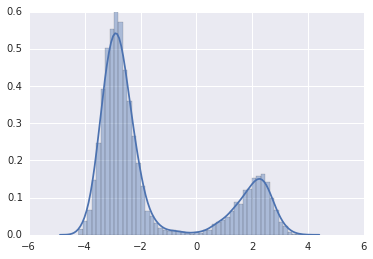

In [70]:
# histogram and kde of the samples
sns.distplot(LMTMsamples)

Clearly, under the same settings, Langevin-within-MTM can correctly draw samples from the target instead of getting stuck at a local mode.

## 4.  Discussions and conclusions

As stated before, this project will focus on developing the code for the algorithms since there is no existing code found for MTM algorithm and its variations. In fact, the code above has already adapted to vectorization and optimized using jit tools. If we have more time, we will try to use multiple cores and C++ to further optimize the code. However, as we discussed in the previous section, MCMC algorithm is limited to perform in parallel since a Markov chain can only be constructed by sequential sampling mechanism. 

Based on our analysis above, we clearly illustrate that the Multiple-try Metropolis is an efficient algorithm for exploring the whole state space and can be adapted based on the specific problems. Its general form allows for combining with other MCMC algorithms and take advantages of local optimization tools. Since it enlarges searching space, the acceptance rate is higher and the autocorrelation between samples is smaller. Both of these two properties lead to more reliable inferences in terms of the samples. 

Parallel computation based on MTM is of interest. A stochastic version can be constructed but hard to show the convergence rate. Therefore, some theoretical foundations and approximate algorithms need to be constructed in the future.

## References

[1] Christian Ritter & Martin A. Tanner (1992) Facilitating the Gibbs sampler: the Gibbs stopper and the griddy-Gibbs sampler. *Journal of the American Statistical Association*, 87.419 (1992): 861-868.

[2] Douglas M. Bates & Donald G. Watts (1988) *Nonlinear Regression: Iterative Estimation and Linear Approximations, in Nonlinear Regression Analysis and Its Applications*. John Wiley & Sons, Inc., Hoboken, NJ, USA. doi: 10.1002/9780470316757.ch2

[3] Faming Liang, Chuanhai Liu & Raymond Carroll (2011) *Advanced Markov chain Monte Carlo methods: learning from past samples* vol:714 John Wiley & Sons

[4] Nan Ding et al (2014) Bayesian sampling using stochastic
gradient thermostats. *NIPS, 2014*

[5] Jun S. Liu (2001)  *Monte Carlo Strategies in Scientific Computing* Statistics, Springer-Verlag, New York

[6] Jun S. Liu, Faming Liang & Wing Hung Wong (2001) The Multiple-try method and local optimization in Metropolis Sampling. *Journal of the American Statistical Association*, 95:449, pp. 121-134

[7] Radford M. Neal (2011) MCMC using Hamiltonian dynamics. In Steve Brooks et al. (eds.)  *Handbook of Markov chain Monte Carlo* Chapter 5, Chapman & Hall/CRC Press